# Algo - simulation COVID

Ou comment utiliser les mathématiques pour comprendre la propagation de l'épidémie.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Enoncé


### On récupère les données du COVID par région et par âge et premier graphe

A cette adresse : [Données relatives à l’épidémie de COVID-19 en France : vue d’ensemble](https://www.data.gouv.fr/en/datasets/donnees-relatives-a-lepidemie-de-covid-19-en-france-vue-densemble/)

In [3]:
from pandas import read_csv, to_datetime
url = "https://www.data.gouv.fr/en/datasets/r/d3a98a30-893f-47f7-96c5-2f4bcaaa0d71"
covid = read_csv(url, sep=",")
covid['date'] = to_datetime(covid['date'])
covid.tail()

,date,total_cas_confirmes,total_deces_hopital,total_deces_ehpad,total_cas_confirmes_ehpad,total_cas_possibles_ehpad,patients_reanimation,patients_hospitalises,total_patients_gueris,nouveaux_patients_hospitalises,nouveaux_patients_reanimation
240,2020-09-03,300181.0,20192.0,10514.0,40300.0,NaN,464.0,4643.0,87206.0,307.0,55.0
241,2020-10-28,1235132.0,24424.0,11361.0,62297.0,NaN,3045.0,20207.0,113977.0,2821.0,372.0
242,2020-10-13,756472.0,22077.0,10856.0,48845.0,NaN,1642.0,8949.0,102680.0,1168.0,226.0
243,2020-10-07,653509.0,21660.0,10785.0,46520.0,NaN,1416.0,7536.0,99793.0,789.0,143.0
244,2020-09-09,344101.0,20319.0,10475.0,40876.0,NaN,599.0,5003.0,88524.0,386.0,71.0


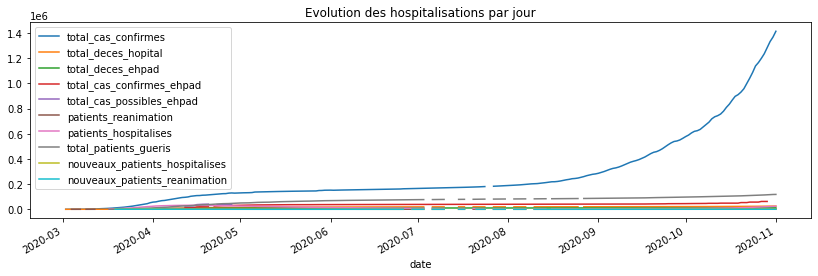

In [4]:
covid.set_index("date").plot(
    title="Evolution des hospitalisations par jour", figsize=(14, 4));

Il y a quelques valeurs manquantes même pour les séries aggrégées... Comme je n'ai pas le courage de corriger les valeurs unes à unes, je prends un autre fichier.

In [5]:
from pandas import concat, to_datetime

def extract_data(kind='deaths', country='France'):
    url = (
        "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/"
        "master/csse_covid_19_data/"
        "csse_covid_19_time_series/time_series_covid19_%s_global.csv" %
        kind)
    df = read_csv(url)
    eur = df[df['Country/Region'].isin([country])
             & df['Province/State'].isna()]
    tf = eur.T.iloc[4:]
    tf.columns = [kind]
    return tf

def extract_whole_data(kind=['deaths', 'confirmed', 'recovered'],
                       country='France'):
    population = {
        'France': 67e6,
    }

    total = population[country]
    dfs = []
    for k in kind:
        df = extract_data(k, country)
        dfs.append(df)
    conc = concat(dfs, axis=1)
    conc['infected'] = conc['confirmed'] - (conc['deaths'] + conc['recovered'])
    conc['safe'] = total - conc.drop('confirmed', axis=1).sum(axis=1)
    conc.index = to_datetime(conc.index)
    
    return conc

covid = extract_whole_data()
covid.tail()

,deaths,confirmed,recovered,infected,safe
2020-10-27,35268,1206014,92830,1077916,65793986.0
2020-10-28,35493,1240862,94048,1111321,65759138.0
2020-10-29,35728,1288478,95358,1157392,65711522.0
2020-10-30,36273,1337693,96604,1204816,65662307.0
2020-10-31,36494,1373036,97475,1239067,65626964.0


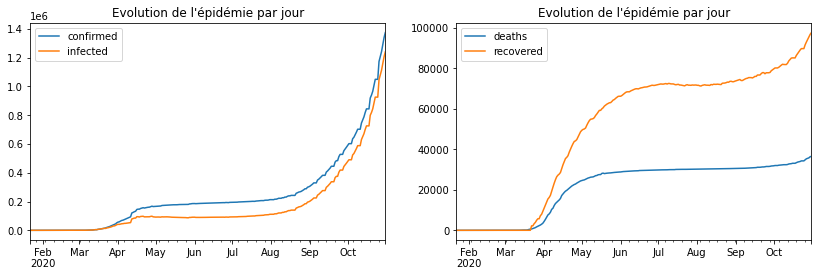

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
covid[['confirmed', 'infected']].plot(title="Evolution de l'épidémie par jour", ax=ax[0])
covid[['deaths', 'recovered']].plot(title="Evolution de l'épidémie par jour", ax=ax[1]);

On lisse.

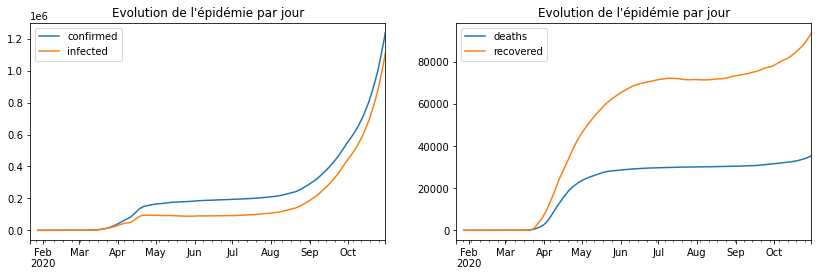

In [7]:
lisse = covid.rolling(7).mean()
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
lisse[['confirmed', 'infected']].plot(title="Evolution de l'épidémie par jour", ax=ax[0])
lisse[['deaths', 'recovered']].plot(title="Evolution de l'épidémie par jour", ax=ax[1]);

La série des *recovered* ne compte vraisemblablement que ceux qui sont passés à l'hôpital. Il faudrait recouper avec d'autres données pour être sûr. Ce sera pour un autre jour.

### Modèle [SIRD](http://www.xavierdupre.fr/app/aftercovid/helpsphinx/model_covidsir.html)

Pour en savoir plus [Modèles compartimentaux en épidémiologie](https://fr.wikipedia.org/wiki/Mod%C3%A8les_compartimentaux_en_%C3%A9pid%C3%A9miologie). On classe la population en quatre catégories :

* S : personnes non contaminées
* I : nombre de personnes malades ou contaminantes
* R : personnes guéries (recovered)
* D : personnes décédées

Les gens changent de catégorie en fonction de l'évolution de l'épidémie selon les équations qui suivent :

* $\frac{dS}{dt} = - \beta \frac{S I}{N}$
* $\frac{dI}{dt} = \frac{\beta S I}{N} - \mu I - \nu I$
* $\frac{dD}{dt} = \nu I$
* $\frac{dR}{dt} = \mu I$

$\beta$ est lié au taux de transmission, $\frac{1}{\mu}$ est la durée moyenne jusqu'à guérison, $\frac{1}{\nu}$ est la durée moyenne jusqu'au décès.

### Q0 : une petite fonction pour dessiner

Cette fonction servira à représenter graphiquement les résultats.

In [8]:
from datetime import datetime, timedelta


def plot_simulation(sim, day0=datetime(2020, 1, 1), safe=True,
                    ax=None, title=None, logy=False, two=False,
                    true_data=None):
    """
    On suppose que sim est une matrice (days, 4).
    :param sim: la simulation
    :param day0: le premier jour de la simulation (une observation par jour)
    :param safe: ajouter les personnes *safe* (non infectées), comme elles sont nombreuses,
        il vaut mieux aussi cocher *logy=True* pour que cela soit lisible
    :param ax: axes existant (utile pour superposer), None pour un créer un nouveau
    :param title: titre du graphe
    :param logy: échelle logarithmique sur l'axe des y
    :param two: faire deux graphes plutôt qu'un seul pour plus de visibilité
    :param true_data: vraies données à tracer également en plus de celle de la simulation
    :return: ax
    """
    df = DataFrame(sim, columns=['S', 'I', 'R', 'D'])
    # On ajoute des dates.
    df["date"] = [day0 + timedelta(d) for d in range(0, df.shape[0])]
    df = df.set_index("date")
    if true_data is None:
        tdf = None
    else:
        tdf = DataFrame(true_data, columns=['Sobs', 'Iobs', 'Robs', 'Dobs'])
        tdf["date"] = [day0 + timedelta(d) for d in range(0, tdf.shape[0])]
        tdf = tdf.set_index("date")
        
    if two:
        if ax is None:
            fig, ax = plt.subplots(1, 2, figsize=(14, 4))
        if safe:
            if tdf is not None:
                tdf.drop(['Dobs'], axis=1).plot(ax=ax[0], logy=logy, linewidth=8)
            df.drop('D', axis=1).plot(ax=ax[0], title=title, logy=logy, linewidth=4)
        else:
            if tdf is not None:
                tdf.drop(['Sobs', 'Dobs'], axis=1).plot(ax=ax[0], logy=logy, linewidth=8)
            df.drop(['S', 'D'], axis=1).plot(ax=ax[0], title=title, logy=logy, linewidth=4)
        if tdf is not None:
            tdf['Dobs'].plot(ax=ax[1], title=title, logy=logy, linewidth=8)
        df[['D']].plot(ax=ax[1], title='Décès', logy=logy, linewidth=4)
        ax[0].legend()
        ax[1].legend()
    else:
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(14, 4))
        if safe:
            if tdf is not None:
                tdf.plot(ax=ax, title=title, logy=logy, linewidth=8)
            df.plot(ax=ax, title=title, logy=logy, linewidth=4)
        else:
            if tdf is not None:
                tdf.drop(['Sobs'], axis=1).plot(ax=ax, title=title, logy=logy, linewidth=8)
            df.drop(['S'], axis=1).plot(ax=ax, title=title, logy=logy, linewidth=4)
        ax.legend()
    return ax

### Q1 : écrire une fonction qui calcule la propagation

On suppose que $\beta, \mu, \nu, S_0, I_0, R_0, D_0$ sont connus. On rappelle le modèle :

* $dS = - \beta \frac{S I}{N}$
* $dI = \frac{\beta S I}{N} - \mu I - \nu I$
* $dD = \nu I$
* $dR = \mu I$

In [9]:
import numpy

In [10]:
beta = 0.5
mu = 1./14
nu = 1./21
S0 = 9990
I0 = 10
R0 = 0
D0 = 0

Il faudra compléter le petit programme suivant :

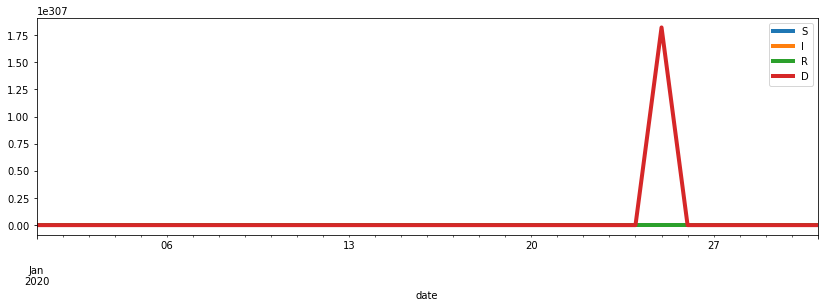

In [11]:
from pandas import DataFrame



def simulation(beta, mu, nu, S0, I0, R0, D0, days=14):
    res = numpy.empty((days+1, 4), dtype=numpy.float64)
    res[0, :] = [S0, I0, R0, D0]
    N = sum(res[0, :])
    for t in range(1, res.shape[0]):
        dR = res[t-1, 1] * mu
        # ....
    return res


sim = simulation(beta, mu, nu, S0, I0, R0, D0, 30)
plot_simulation(sim);

### Q2 : on veut estimer les paramètres du modèle, une fonction d'erreur ?

C'est compliqué parce que... les paramètres évoluent au cours du temps, en fonction du comportement des gens, masque, pas masque, confinement, reconfinement, température, manque de tests également... Tout d'abord les vraies données.

In [12]:
lisse_mars = lisse[30:]
dates = lisse_mars.index
france = numpy.zeros((lisse_mars.shape[0], 4), dtype=numpy.dtype)
france[:, 3] = lisse_mars['deaths']
france[:, 2] = lisse_mars['recovered']
france[:, 0] = lisse_mars['safe']
france[:, 1] = lisse_mars['infected']

france[:5]

array([[66999988.0, 7.0, 4.0, 1.0],
       [66999988.0, 7.0, 4.0, 1.0],
       [66999988.0, 7.0, 4.0, 1.0],
       [66999988.0, 7.0, 4.0, 1.0],
       [66999987.71428572, 6.285714285714286, 5.0, 1.0]], dtype=object)

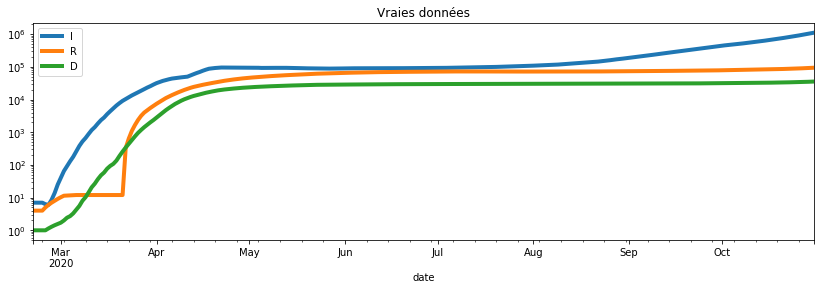

In [13]:
plot_simulation(france, dates[0], safe=False, logy=True, title="Vraies données");

Et sur les derniers jours.

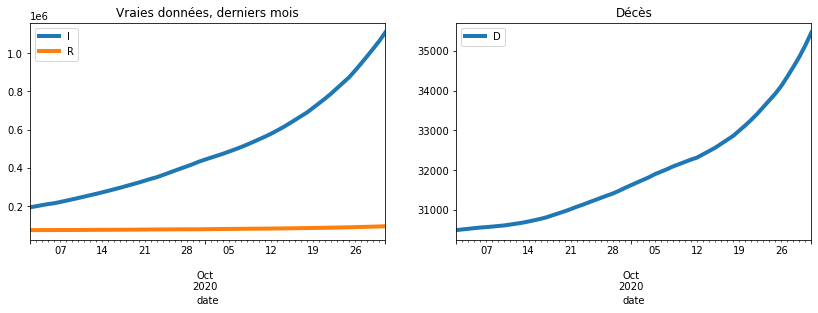

In [14]:
plot_simulation(france[-60:], dates[-60], two=True, safe=False, title="Vraies données, derniers mois");

Bref, on part du principe le modèle est plutôt fiable sur une courte période de temps, on tire plein de paramètres aléatoires et on regarde ce qui marche le mieux. Et pour comparer deux jeux de paramètres, il faut donc une fonction d'erreur qu'on prendra comme égal à la somme des erreurs de prédictions.

Maintenant il faut faire attention à ce qu'on compare. La simulation calcule les catégories de population au temps *t*, mais pas toujours les séries cumulées. La série des personnes contaminées est **transitoire dans la simulation** et **cumulées dans les données récupérées**. La première étape consiste à transformer les données simulées pour qu'elles soient comparables aux données collectées.

In [15]:
def simulation_cumulee(beta, mu, nu, S0, I0, R0, D0, days=14):
    # ...
    pass

Maintenant la fonction d'erreur :

In [16]:
def error(data, simulation):
    # ... à compléter
    return 0

### Q3 : optimisation

Pour optimiser, on tire des paramètres de façon aléatoire dans un intervalle donné et on choisit ceux qui minimisent l'erreur.

In [17]:
from tqdm import tqdm  # pour avoir une barre de progression


def optimisation(true_data, i_range=(0, 0.2), beta_range=(0, 0.5),
                 mu_range=(0., 0.2), nu_range=(0., 0.2),
                 max_iter=1000, error_fct=error):
    N = sum(true_data[0, :])
    rnd = numpy.random.rand(max_iter, 4)
    for i, (a, b) in enumerate([i_range, beta_range, mu_range, nu_range]):
        rnd[:, i] = rnd[:, i] # à compléter ... 
        
    err_min = None
    for it in tqdm(range(max_iter)):
        i, beta, mu, nu = rnd[it, :]
        
        D0 = true_data[0, 3]
        # dI0 = 
        # S0 = 
        # I0 = 
        # R0 = 
        sim = simulation_cumulee(beta, mu, nu, S0, I0, R0, D0, days=true_data.shape[0] - 1)
        err = error_fct(true_data, sim)
        if err_min is None or err < err_min:
            # à compléter
            pass
    return best

### Q4 : dessiner les résultats

### Q5 : vérifier que cela marche sur des données synthétiques

On simule, on vérifie que l'optimisation retrouve les paramètres de la simulation.

### Q6 : sur des données réelles

## Réponses

### Q1 : propagation

On l'applique aux données réelles.

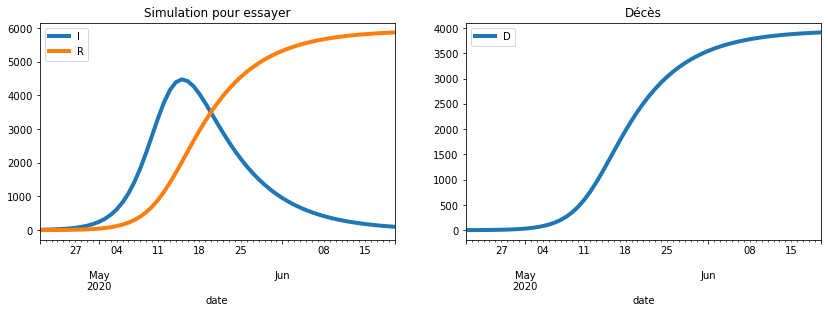

In [23]:
from datetime import datetime, timedelta
from pandas import DataFrame


def simulation(beta, mu, nu, S0, I0, R0, D0, days=14):
    res = numpy.empty((days+1, 4), dtype=numpy.float64)
    res[0, :] = [S0, I0, R0, D0]
    N = sum(res[0, :])
    for t in range(1, res.shape[0]):
        dR = res[t-1, 1] * mu
        dD = res[t-1, 1] * nu
        dI = res[t-1, 0] * res[t-1, 1] / N * beta
        res[t, 0] = res[t-1, 0] - dI
        res[t, 1] = res[t-1, 1] + dI - dR - dD
        res[t, 2] = res[t-1, 2] + dR
        res[t, 3] = res[t-1, 3] + dD
    return res    


beta = 0.5
mu = 1./14
nu = 1./21
S0 = 9990
I0 = 10
R0 = 0
D0 = 0

sim = simulation(beta, mu, nu, S0, I0, R0, D0, 60)
plot_simulation(sim, dates[60], safe=False, two=True,
                title="Simulation pour essayer");

### Q2 : série cumulées et fonction erreur


On doit d'abord calculer la simulation qui modifie $I_t$ en $J_t$ qui correspond à l'ensemble des personnes contaminées jusqu'à présent.

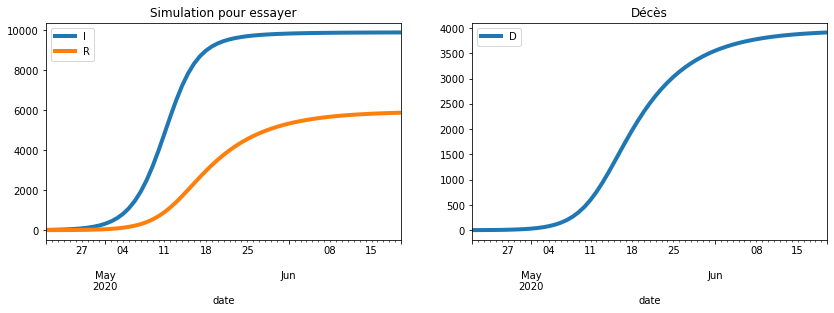

In [24]:
def simulation_cumulee(beta, mu, nu, S0, I0, R0, D0, days=14):
    res = numpy.empty((days+1, 4), dtype=numpy.float64)
    cum = numpy.empty((days+1, 1), dtype=numpy.float64)
    res[0, :] = [S0, I0, R0, D0]
    cum[0, 0] = I0
    N = sum(res[0, :])
    for t in range(1, res.shape[0]):
        dR = res[t-1, 1] * mu
        dD = res[t-1, 1] * nu
        dI = res[t-1, 0] * res[t-1, 1] / N * beta
        res[t, 0] = res[t-1, 0] - dI
        res[t, 1] = res[t-1, 1] + dI - dR - dD
        res[t, 2] = res[t-1, 2] + dR
        res[t, 3] = res[t-1, 3] + dD
        cum[t, 0] = cum[t-1, 0] + dI
    res[:, 1] = cum[:, 0]
    return res

beta = 0.5
mu = 1./14
nu = 1./21
S0 = 9990
I0 = 10
R0 = 0
D0 = 0

sim = simulation_cumulee(beta, mu, nu, S0, I0, R0, D0, 60)
plot_simulation(sim, dates[60], safe=False, two=True,
                title="Simulation pour essayer");

On compare avec les vraies données en gras.

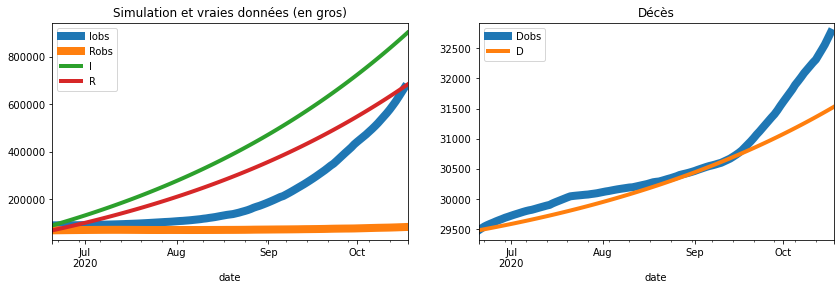

In [25]:
beta = 0.04
mu = 0.03
nu = 0.0001
S0, I0, R0, D0 = france[120, :]
sim = simulation_cumulee(beta, mu, nu, S0, I0, R0, D0, 120)
plot_simulation(sim, dates[120], safe=False, two=True, true_data=france[120:240],
                title="Simulation et vraies données (en gros)");

Pas simple de choisir des paramètres pour approximer la courbe.

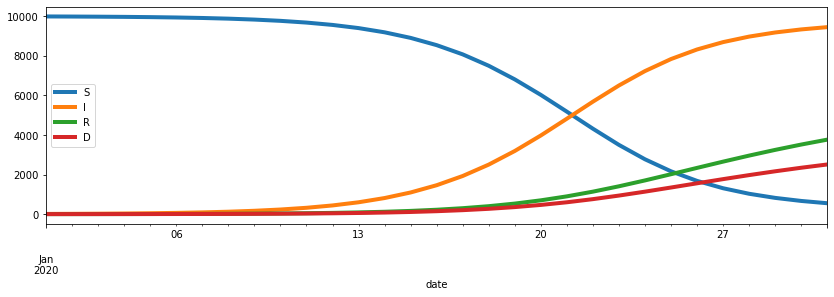

In [26]:
def error(data, simulation):
    "Matrices (:, 4) = (:, [S, I, R, D])"
    diff = simulation - data
    error = diff[:, 3] ** 2
    error += numpy.abs(-diff[:, 2]) ** 2
    error += numpy.abs(-diff[:, 1]) ** 2
    error += numpy.abs(diff[:, 0]) ** 2
    return error.ravel().sum() ** 0.5 / data.shape[0]


beta = 0.5
mu = 1./14
nu = 1./21
S0 = 9990
I0 = 10
R0 = 0
D0 = 0

sim = simulation_cumulee(beta, mu, nu, S0, I0, R0, D0, 30)
plot_simulation(sim);

On regarde si on arrive à retrouver les paramètres de la simulation.

### Q3, Q4, Q5 : optimisation sur des données synthétiques

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 5192.18it/s]


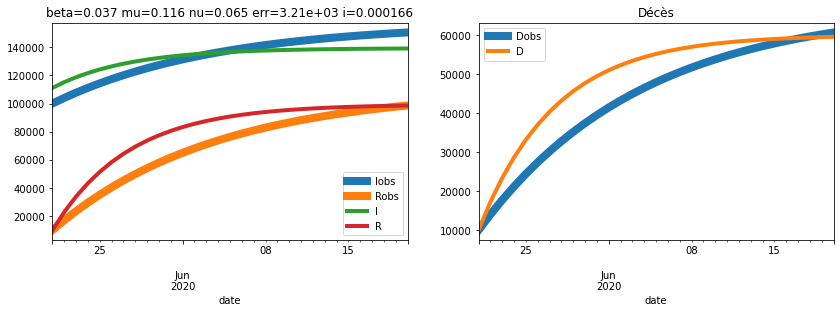

In [27]:
from tqdm import tqdm


def optimisation(true_data, i_range=(0, 0.2), beta_range=(0, 0.5),
                 mu_range=(0., 0.2), nu_range=(0., 0.2),
                 max_iter=1000, error_fct=error):
    N = sum(true_data[0, :])
    rnd = numpy.random.rand(max_iter, 4)
    for i, (a, b) in enumerate([i_range, beta_range, mu_range, nu_range]):
        rnd[:, i] = rnd[:, i] * (b - a) + a
    err_min = None
    for it in tqdm(range(max_iter)):
        i, beta, mu, nu = rnd[it, :]
        dI0 = true_data[0, 0] * i
        D0 = true_data[0, 3]
        S0 = true_data[0, 0] - dI0
        I0 = true_data[0, 1] + dI0
        R0 = N - D0 - I0 - S0
        sim = simulation_cumulee(beta, mu, nu, S0, I0, R0, D0, days=true_data.shape[0] - 1)
        err = error_fct(true_data, sim)
        if err_min is None or err < err_min:
            err_min = err
            best = dict(beta=beta, mu=mu, nu=nu, I0=I0, i=i,
                        S0=S0, R0=R0, D0=D0, err=err, sim=sim)
    return best


beta = 0.04
mu = 0.07
nu = 0.04
S0 = 67e6
I0 = 100000
R0 = 10000
D0 = 10000
sim = simulation_cumulee(beta, mu, nu, S0, I0, R0, D0, 30)


res = optimisation(sim, max_iter=2000, error_fct=error, i_range=(0., 0.001))
sim_opt = res['sim']
del res['sim']
plot_simulation(sim_opt, dates[90], safe=False, two=True, true_data=sim,
                title="beta=%1.3f mu=%1.3f nu=%1.3f err=%1.3g i=%1.3g" % (
                    res['beta'], res['mu'], res['nu'], res['err'], res['i']));

Ca ne marche pas trop mal.

### Q6 : sur des données réelles

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1997.32it/s]


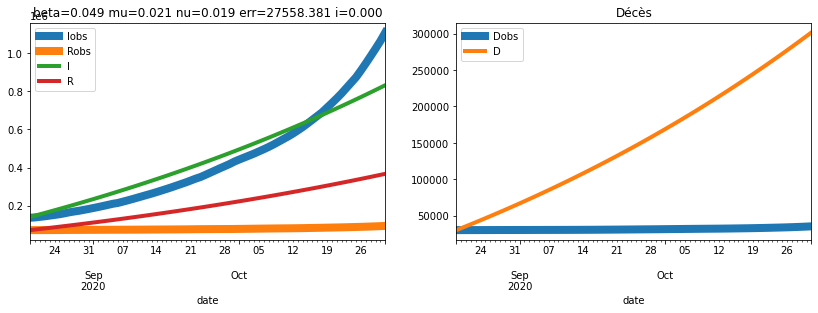

In [28]:
res = optimisation(france[180:], error_fct=error, i_range=(0, 0.0001))
sim = res['sim']
del res['sim']
plot_simulation(sim, dates[180], safe=False, two=True, true_data=france[180:],
                title="beta=%1.3f mu=%1.3f nu=%1.3f err=%1.3f i=%1.3f" % (
                    res['beta'], res['mu'], res['nu'], res['err'], res['i']));

Ca ne marche pas super. On peut modifier l'erreur pour ne compter que la courbe des morts.

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1739.33it/s]


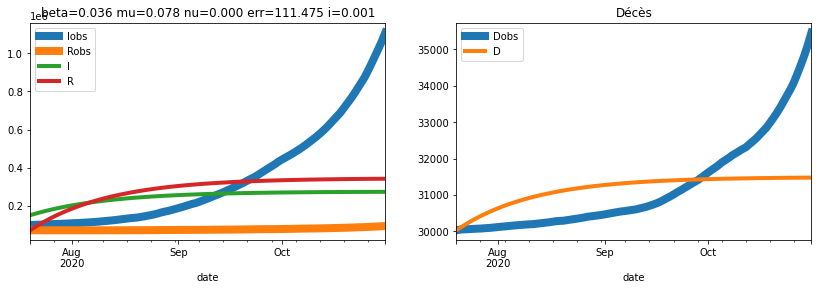

In [29]:
def errorD(data, simulation):
    "Matrices (:, 4) = (:, [S, I, R, D])"
    diff = simulation - data
    err = diff[:, 3] ** 2
    return err.ravel().sum() ** 0.5 / data.shape[0]

res = optimisation(france[150:], error_fct=errorD, i_range=(0, 0.001))
sim = res['sim']
del res['sim']
plot_simulation(sim, dates[150], safe=False, two=True, true_data=france[150:],
                title="beta=%1.3f mu=%1.3f nu=%1.3f err=%1.3f i=%1.3f" % (
                    res['beta'], res['mu'], res['nu'], res['err'], res['i']));

L'erreur est répartie sur l'ensemble de la courbe mais cela ne tient pas compte de la dynamique. Il faudrait prendre en compte les dérivées comme dans l'aticle [A Modified SIR Model for the COVID-19 Contagion in Italy](https://arxiv.org/pdf/2003.14391.pdf). Ou partir sur une approche plus directe comme celle proposée dans l'article [Estimating and Simulating a SIRD Model of COVID-19 for Many Countries, States, and Cities](https://web.stanford.edu/~chadj/sird-paper.pdf). $\frac{dS}{dt} = - \beta \frac{S I}{N}$ implique que $\Delta(S_t) = S_{t+1} - S_t = -\beta \frac{S_t I_t}{N}$. On peut alors calculer une sorte de $\beta_t$ dépendant du temps : $\beta_t = -N\frac{S_{t+1} - S_t}{S_t I_t}$. Le problème, c'est $I_t$ qu'on ne connaît pas puisque c'est le nombre de personnes contaminantes à un instant *t*. On ne connaît pas plus $S_t$ mais on peut le déduire si on connaît $I_t$. Cela dit, le paramètre $\nu$ est plus ou moins connu puisqu'il s'agit de l'inverse de la durée moyenne d'incubation jusqu'au décès. De là, on peut retrouver $\beta$. On poursuit en passant au logarithme $\ln \beta_t = \ln N + \ln (S_t - S_{t+1}) - \ln S_t - \ln I_t$. Le nombre de cas positifs découverts chaque jour correspond à $S_t - S_{t+1}$. On ajoute que $\forall t, N = S_t + I_t + R_t + D_t$ et $D_{t+1} - D_t = \nu I_t$. Donc :

$$\ln \beta_t = \ln N + \ln (S_t - S_{t+1}) - \ln (S_t - S_{t-1} + S_{t-1}) - \ln (D_{t+1} - D_t) + \ln \nu$$

Il y a deux inconnues, $\ln \beta - \ln \nu$ qu'on suppose constant pendant la période et $S_{t-1}$. Il suffit d'écrire ces équations sur quelques jours puis de résoudre le système d'équations.

$$\begin{array}{l}
\ln \beta - \ln \nu = \ln N + \ln (S_t - S_{t+1}) - \ln (S_t - S_{t-1} + S_{t-1}) - \ln (D_{t+1} - D_t) \\
\ln \beta - \ln \nu = \ln N + \ln (S_{t+1} - S_{t+2}) - \ln (S_{t+1} - S_{t} + S_{t} - S_{t-1} + S_{t-1}) - \ln (D_{t+2} - D_{t+1}) 
\end{array}$$


D'autres directions sont possibles comme [The Parameter Identification Problem for SIR Epidemic Models: Identifying Unreported Cases](https://www.math.u-bordeaux.fr/~pmagal100p/papers/MW-JMB-2018.pdf) qui propose d'estimer les paramètres sur une plus grande période.


D'autres articles : [Introduction to inference: parameter estimation](https://kingaa.github.io/clim-dis/parest/parest.html), [Data-based analysis, modelling and forecasting of the COVID-19 outbreak](https://europepmc.org/article/med/32231374), [Identification and estimation of the SEIRD epidemic model for COVID-19](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7392128/).